# Data Clean up

Haytham Mohamed - INFS890 Spring 2020

This notebook is to clean orders flow data

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import preprocessing
from datetime import datetime
from scipy import stats

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

# Read the raw data. 

All data is in one file, where each metric is listed under each other with three columns: 

1- metric: The name of the metric

2- date: the data and time of the metric

3- value: the metric value


In [272]:
# 1- read processed file

home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'

file_dir = home_dir + '/processed-data/'
input_file = 'orders_flow_data.csv'

save=True

In [273]:
def read_df(file_dir, data_file):
    df = pd.read_csv(file_dir + data_file)
    return to_time_series(df)

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df
    

In [274]:
orders_flow_df = read_df(file_dir, input_file)
orders_flow_df.head(5) 

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,nodes_cpu_use,orders_ltcy
date,,,,,,,,,,,
2020-03-27 00:00:22,0.020,0.170,0.010,0.020,0.020,0.560,0.020,0.570,0.010,1.840,0.240
2020-03-27 00:00:37,0.030,0.180,0.010,0.020,0.010,0.560,0.020,0.580,0.010,1.890,0.240
2020-03-27 00:00:52,0.050,0.080,0.010,0.030,0.020,0.470,0.020,0.640,0.080,1.740,0.240
2020-03-27 00:01:07,0.100,0.090,0.010,0.030,0.020,0.280,0.020,0.630,0.200,1.790,0.240
2020-03-27 00:01:22,0.110,0.180,0.010,0.040,0.020,0.090,0.020,0.520,0.220,1.610,0.240


In [275]:
orders_flow_df.shape


(5750, 11)

Take away records with ltcy or number of pods null or equals to zero

In [276]:
orders_flow_df = orders_flow_df[orders_flow_df['orders_ltcy'].notna()]
orders_flow_df.shape

(5750, 11)

In [277]:
orders_flow_df = orders_flow_df[orders_flow_df['orders_ltcy'] >= 0]
orders_flow_df.shape

(5750, 11)

In [278]:
orders_flow_df.describe(include="all")

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,nodes_cpu_use,orders_ltcy
count,"5,750.000","5,750.000","5,750.000","5,750.000","5,750.000","5,750.000","5,750.000","5,750.000","5,750.000","5,750.000","5,750.000"
mean,0.865,0.215,0.021,0.203,0.119,0.055,0.035,0.566,1.842,4.173,3.344
std,0.653,0.137,0.005,0.141,0.084,0.034,0.010,0.615,2.027,2.173,3.599
min,0.020,0.020,0.010,0.020,0.010,0.020,0.010,0.050,0.010,1.230,0.090
25%,0.080,0.050,0.020,0.040,0.020,0.040,0.030,0.070,0.020,1.393,0.240
50%,0.960,0.220,0.020,0.210,0.120,0.050,0.040,0.310,1.155,4.370,1.364
75%,1.350,0.310,0.020,0.310,0.190,0.060,0.040,1.010,3.300,5.960,6.837
max,2.730,0.910,0.040,0.640,0.340,0.630,0.100,2.530,6.580,9.660,9.750


# Check missing values

In [279]:
# percent of missing value for every feature
orders_flow_df.isnull().sum() * 100 / orders_flow_df.shape[0]

front-end_cpu_use   0.000
orders_cpu_use      0.000
orders-db_cpu_use   0.000
user_cpu_use        0.000
user-db_cpu_use     0.000
shipping_cpu_use    0.000
payment_cpu_use     0.000
carts_cpu_use       0.000
carts-db_cpu_use    0.000
nodes_cpu_use       0.000
orders_ltcy         0.000
dtype: float64

# Check Outliers

### latency target 

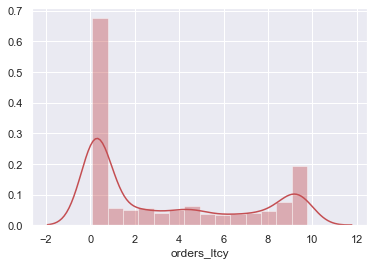

In [280]:
sns.distplot(orders_flow_df['orders_ltcy'], hist=True, rug=False, color="r", label='ltcy')

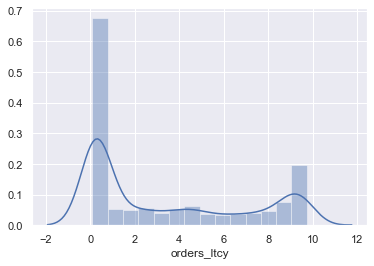

In [281]:
# taking percentile out (between lower and upper limit)
# looks like first half of latency is between 0.24 and 1.361, the other half is 2 and up to 9.7
# acceptable outliers in services latency, I'll consider it. so take all data (0 to 100%)
# i.e. not to trim any portion from either edges

df2 = orders_flow_df
if 1 == 1:
    minq = df2['orders_ltcy'].quantile(0)
    maxq = df2['orders_ltcy'].quantile(1)
    df2 = df2[df2['orders_ltcy'] > minq]
    df2 = df2[df2['orders_ltcy'] < maxq]
    sns.distplot(df2['orders_ltcy'])

The scaled latency distribution shows now an exponential graph. Taking the log and plotting it would remedy the skewness.

In [282]:
df2.shape

(5711, 11)

In [283]:
df2.describe(include="all")

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,nodes_cpu_use,orders_ltcy
count,"5,711.000","5,711.000","5,711.000","5,711.000","5,711.000","5,711.000","5,711.000","5,711.000","5,711.000","5,711.000","5,711.000"
mean,0.862,0.215,0.021,0.202,0.119,0.055,0.035,0.562,1.852,4.171,3.356
std,0.654,0.137,0.005,0.141,0.084,0.034,0.010,0.614,2.028,2.179,3.597
min,0.020,0.020,0.010,0.020,0.010,0.020,0.010,0.050,0.010,1.230,0.096
25%,0.070,0.050,0.020,0.040,0.020,0.040,0.030,0.060,0.020,1.360,0.240
50%,0.960,0.220,0.020,0.200,0.120,0.050,0.040,0.310,1.170,4.380,1.424
75%,1.350,0.310,0.020,0.310,0.190,0.060,0.040,1.000,3.320,5.970,6.854
max,2.730,0.910,0.040,0.640,0.340,0.630,0.100,2.530,6.580,9.660,9.730


In [284]:
orders_flow_df = df2
if save:
    processed_file_path = file_dir + 'order_flow_cleanup_data.csv'
    orders_flow_df.to_csv(path_or_buf=processed_file_path, index=True)